### Implementation of Mistic 
to our binary description of patient data

In [534]:
import os
starting_directory = os.getcwd()
print(os.getcwd())

C:\Users\maega\UFL Dropbox\Maegan Cremer\research-share\Maegan\Projects\Cardiac-Amyloidosis-Multiple-Myeloma\012 Processed Data


### libraries and dirrectories

### directory for mistic

In [535]:
#set dirrectory
import os
starting_directory = os.getcwd()

#for getting mistic

#updates to directory management
# machine_directory = 'C:/Users/mcremer' #the C and path to the project folder
machine_directory = 'C:/Users/maega' #when working from home machine
storage_directory = 'UFL Dropbox/Maegan Cremer/research-share/Maegan/Projects' #Local, HPG, or dropbox
project_directory = 'Shared-From-DrK/mistic_breast_cancer_example/mistic_breast_cancer_example' #project folder
# project_lv2_directory = '013 Analyzed Data outputs' #deeper part of project folder

path = os.path.join(machine_directory, storage_directory, 
                    project_directory)

new_dirrectory = path

os.chdir(new_dirrectory)



In [536]:
# Import packages/modules
import matplotlib.pyplot as plt   
plt.rcParams.update({'font.size': 8})

import numpy as np
import pandas as pd

from statistics import mean 
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from seaborn import clustermap, heatmap

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics.pairwise import rbf_kernel

# Import functions
from mistic_v1 import greedy_backward_selection, tuneSVM, compute_SV_feature_importance, compute_counterfactuals #, compute_SV_feature_contribution
from mistic_v1 import compute_SV_gradient_rank2, compute_SV_importance_rank, compute_SV_contribution_rank, compute_SV_decision_perturbation

In [537]:
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.calibration import calibration_curve
from scipy.stats import pearsonr
from mistic_v1 import rank_items

class SV_combined_rank():

    def __init__(self,weight=0.5):
        self.weight = weight

    def compute(self,svc,X,y):
        contribution_rank = compute_SV_contribution_rank(svc,X,y)
        importance_rank = compute_SV_importance_rank(svc,X,y)

        consensus_rank = self.weight*contribution_rank + (1-self.weight)*importance_rank
        rank = rank_items(consensus_rank)
        
        return rank

class svc_score():

    def __init__(self, weight=0.5):
        self.weight = weight

    def score(self,svc,X,y):
        y_pred = svc.predict(X)
        
        tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

        if (tp+fp) > 0:
            precision = tp/(tp+fp)
        else:
            precision = 0
            
        if (tp+fn) > 0:
            recall = tp/(tp+fn)
        else:
            recall = 0
        
        if (precision+recall) > 0:
            f1 = 2*precision*recall/(precision+recall)
        else:
            f1 = 0
            
        auc = roc_auc_score(y, svc.decision_function(X))
        score = self.weight*auc + (1-self.weight)*f1
            
        return pd.DataFrame(data={'f1': f1, 'auc': auc, 'score': score},index=[0])


In [538]:
import shap
from mistic_v1 import compute_SV_integrated_gradient

In [539]:
import plotly.express as px
from seaborn import pairplot, load_dataset

In [540]:
import numpy as np
import pickle

In [541]:
#some functions I wrote to help with exporting data
def outputToExcel(df_data, fileName_header, fileName_Common, fileName_suffix,
                  parent_dir, folderName, sheetName):
    fileName = fileName_header + fileName_Common + fileName_suffix
    outfile_extension = '.xlsx'
    outfile_boxplts = fileName + outfile_extension
    path_out= os.path.join(parent_dir, folderName, outfile_boxplts)

    if os.path.exists(path_out):
            #if old sheet
            with pd.ExcelWriter(path_out, mode = 'a', if_sheet_exists = 'overlay') as writer:
                    df_data.to_excel(writer, sheet_name = sheetName, index = True)
    else: 
            #new sheet
            with pd.ExcelWriter(path_out) as writer:
                    df_data.to_excel(writer, sheet_name = sheetName, index = True) #if new sheet
    
def outputFiguresPath(fileName_header, fileName_mid, fileName_suff, parent_dir, folderName):
        fileName_header = str(fileName_header)
        fileName_mid = str(fileName_mid)
        fileName_suff = str(fileName_suff)

        #cleaning the input to prevent addition of / to the directory
        fileName_header = fileName_header.replace("/", "-")
        fileName_mid = fileName_mid.replace("/", "-")
        fileName_suff = fileName_suff.replace("/", "-")

        fileName = fileName_header + fileName_mid +fileName_suff
        out_filename = fileName + '.tif'
        new_filepath = os.path.join(parent_dir, folderName, out_filename)
        #the output path can be used to save the figure
        return new_filepath
        # plt.savefig(new_filepath, bbox_inches = 'tight')

def makeFolderPathForData(parent_dir, folderName_header, folderName_common, folderName_suffix):
    #makes a new directory for your files
    #returns the folder name for use in other functions
    folderName = folderName_header + folderName_common + folderName_suffix
    path = os.path.join(parent_dir,folderName)
    if not os.path.exists(path):
        os.mkdir(path)
    return folderName

### importing our data

In [542]:
#updates to directory management
# machine_directory = 'C:/Users/mcremer' #the C and path to the project folder
machine_directory = 'C:/Users/maega' #when working from home machine
storage_directory = 'UFL Dropbox/Maegan Cremer/research-share/Maegan/Projects' #Local, HPG, or dropbox
project_directory = 'Cardiac-Amyloidosis-Multiple-Myeloma' #project folder
project_lv2_directory = '012 Processed Data' #deeper part of project folder

path = os.path.join(machine_directory, storage_directory, 
                    project_directory, project_lv2_directory)

parent_dir = path
os.chdir(parent_dir)

### where data was pickled

In [543]:
#consider changing dirrectory back to a space to save your data that isn't the mistic folder

#for file outputs
fileName_header = "top60E_240806_Red01" #what data did you put in
fileName_common = "_Mistic_" #what was performed on the data, for figures, this may be added to
fileName_suffix = "_2024-08-06_v1" #date and versioning

# saving_dirrectory = "C:/Users/maega/Documents/3000 PhD/3300_BEAT Labs/Projects/Cardiac-Amyloidosis-Multiple-Myeloma/012 Processed Data/"
saving_dirrectory = "012 Processed Data"
# makingFolder = makeFolderPathForData(parent_dir= saving_dirrectory, folderName_header= "SVM_Mistic_top60E_woEcho_Red01_corrOFF", folderName_common= "2024-08-08_", 
#                                      folderName_suffix= "v1")
makingFolder = os.path.join(parent_dir, "SVM_Mistic_top60E_Red01_2024-08-06_v1")
dataFrameFolderOut =  makingFolder #"SVM_Mistic_Output_2024-07-19_v2"
pickleFolderOut = makingFolder

figDirectory = "012 Processed Data"
figFolder = makingFolder #"SVM_Mistic_Output_2024-07-19_v2"

# "C:\Users\maega\UFL Dropbox\Maegan Cremer\research-share\Maegan\Projects\Cardiac-Amyloidosis-Multiple-Myeloma\012 Processed Data\SVM_Mistic_top60E_woEcho_Red01_2024-08-07_v1"

### original data input

In [544]:
#file name for inputs
#include the point from 012 onwards 
fileInput_directory = 'DFsForSVM_top60E_2024-08-06_v1\AL-KnownPts_top60E_1Sheet_2024-08-06_v1.xlsx'
# fileInput_directory = 'AL-KnownPts_top60E_woEcho_1Sheet_2024-08-06_v1.xlsx'

In [545]:
# # Import dataset

dataTable = pd.read_excel(fileInput_directory, header = 0)
dataTable

,DeID,Amyloid Status,Dx,Sex,Age,Survival (in months),time from diagnosis to first echo (months),1st_EF(avg%),1st_Diastolic grade,1st_BSA,...,ChemoTx,ChemoTx Number,ImmunoTx,ImmunoTx Number,HemeTx,HemeTx Number,RadTx,RadTx Number,OtherTx,OtherTx Number
0,B-02,2,1,0,48,9.466667,4.433333,67.5,1,1.80,...,0,0,0,0,0,0,0,0,0,0
1,C-03,2,2,1,59,17.000000,-0.033333,62.5,2,1.73,...,1,2,0,0,0,0,0,0,0,0
2,E-01,2,1,0,50,71.300000,21.666667,62.0,0,2.17,...,0,0,0,0,0,0,0,0,0,0
3,E-02,2,1,0,64,20.466667,2.100000,60.0,1,-1.00,...,0,0,0,0,0,0,0,0,0,0
4,F-03,2,2,0,61,52.000000,-1.000000,-1.0,-1,-1.00,...,1,4,0,0,1,1,0,0,0,0
5,G-01,2,2,0,70,104.000000,102.166667,55.0,2,-1.00,...,0,0,1,1,0,0,0,0,0,0
6,G-02,2,2,1,36,30.000000,4.400000,50.0,3,2.12,...,0,0,0,0,0,0,0,0,0,0
7,I-01,2,2,1,55,33.000000,1.133333,62.5,1,1.99,...,1,4,1,2,0,0,0,0,0,0
8,I-03,2,1,0,67,10.033333,1.633333,57.5,1,1.99,...,0,0,0,0,0,0,0,0,0,0
9,J-02,2,2,1,68,26.000000,0.900000,47.5,-1,1.56,...,1,1,1,1,0,0,0,0,0,0


In [546]:
#columns to drop from the x data (samples and features)
x_columns_toDrop = ['DeID', 'Amyloid Status']


#columns to use for the y data 
y_column_Classification = 'Amyloid Status'

### scale data

In [547]:
# Scale input X
X = dataTable.copy()
X.drop(columns= x_columns_toDrop,inplace=True)
scaler = StandardScaler()
scaler.fit(X) #computes the mean and STD along the features axis

X_train_all = scaler.transform(X) #standardization by centering and scaling
y_train_all = dataTable[y_column_Classification]
X_train_all

array([[-0.74270874, -0.77459667, -1.52139307, ..., -0.14586499,
        -0.20851441, -0.20851441],
       [ 0.8072921 ,  1.29099445, -0.40879537, ..., -0.14586499,
        -0.20851441, -0.20851441],
       [-0.74270874, -0.77459667, -1.31910258, ..., -0.14586499,
        -0.20851441, -0.20851441],
       ...,
       [-0.74270874, -0.77459667,  0.90609283, ..., -0.14586499,
        -0.20851441, -0.20851441],
       [ 0.8072921 , -0.77459667, -0.40879537, ..., -0.14586499,
        -0.20851441, -0.20851441],
       [-2.29270958,  1.29099445,  0.90609283, ..., -0.14586499,
        -0.20851441, -0.20851441]])

In [548]:
# loading from pickled objects
#to upload a pickled set use this block
pickle_file_name = 'X_train_all_' + fileName_header + fileName_suffix
pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
pickle_file = open(pickle_filePath, 'rb')

#to put data into an object
X_train_all = pickle.load(pickle_file)

#uploading the y train object
pickle_file_name = 'y_train_all_' + fileName_header + fileName_suffix
pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
pickle_file = open(pickle_filePath, 'rb')

#to put data into an object
y_train_all = pickle.load(pickle_file)

### creating the classifier

In [549]:
# Number of training sets
NT = 5 

# Data split ratio
val_size = 1/NT

#Feature selection reduction factor
red_factor = 0.1

In [550]:
#to upload a pickled set use this block
pickle_file_name = 'CV_sets_object_' + fileName_header + fileName_suffix
pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
pickle_file = open(pickle_filePath, 'rb')

#to put data into an object
CV_sets = pickle.load(pickle_file)

In [551]:
C_range = [2**x for x in range(-2,5)] # trade-off between margin and misclassifications.  smaller c, wider margins
gamma_range = [2**x for x in range(-9,1)]

svc = SVC(kernel = 'rbf', class_weight="balanced", probability=False)

In [552]:
#to upload a pickled set use this block
pickle_file_name = 'tesTune_object_' + fileName_header + fileName_suffix
pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
pickle_file = open(pickle_filePath, 'rb')

#to put data into an object
tesTune = pickle.load(pickle_file)

c:\Users\maega\anaconda3\envs\BEAT-Labs_2024-08-02\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning:

Trying to unpickle estimator SVC from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations



In [553]:
tesTune["best_models"][0].classes_

array([1, 2], dtype=int64)

## greedy_backward_selection

### featRank_A fresh compile

featRank_A upload from pickle

In [554]:
#to upload a pickled set use this block
pickle_file_name = 'featRankA_object_' + fileName_header +fileName_suffix
pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
pickle_file = open(pickle_filePath, 'rb')

#to put data into an object
featRank_A = pickle.load(pickle_file)

c:\Users\maega\anaconda3\envs\BEAT-Labs_2024-08-02\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning:

Trying to unpickle estimator SVC from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations



### compile featRank_B 

load featRank_B from pickle

In [555]:
#to upload a pickled set use this block
pickle_file_name = 'featRankB_object_' + fileName_header +fileName_suffix
pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
pickle_file = open(pickle_filePath, 'rb')

#to put data into an object
featRank_B = pickle.load(pickle_file)

c:\Users\maega\anaconda3\envs\BEAT-Labs_2024-08-02\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning:

Trying to unpickle estimator SVC from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations



### compile featRank_C

upload featRank_C from pickle

In [556]:
#to upload a pickled set use this block
pickle_file_name = 'featRankC_object_' + fileName_header + fileName_suffix
pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
pickle_file = open(pickle_filePath, 'rb')

#to put data into an object
featRank_C = pickle.load(pickle_file)

c:\Users\maega\anaconda3\envs\BEAT-Labs_2024-08-02\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning:

Trying to unpickle estimator SVC from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations



### compile featRank_D

In [557]:
#to upload a pickled set use this block
pickle_file_name = 'featRankD_object_' + fileName_header + fileName_suffix
pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
pickle_file = open(pickle_filePath, 'rb')

#to put data into an object
featRank_D = pickle.load(pickle_file)

c:\Users\maega\anaconda3\envs\BEAT-Labs_2024-08-02\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning:

Trying to unpickle estimator SVC from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations



### comple featRank_E

In [558]:
#to upload a pickled set use this block
pickle_file_name = 'featRankE_object_' + fileName_header + fileName_suffix
pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
pickle_file = open(pickle_filePath, 'rb')

#to put data into an object
featRank_E = pickle.load(pickle_file)

c:\Users\maega\anaconda3\envs\BEAT-Labs_2024-08-02\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning:

Trying to unpickle estimator SVC from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations



# Performance Plots

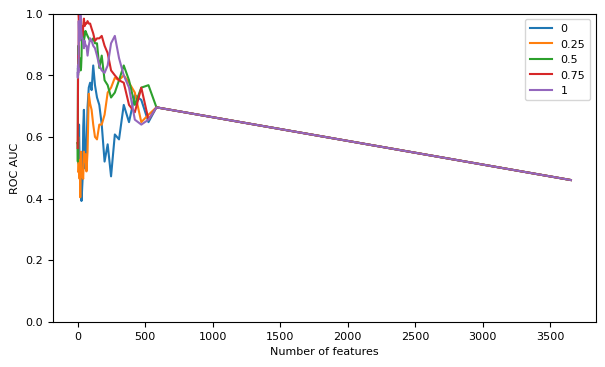

In [559]:
fig, ax = plt.subplots(1,1, figsize=(7, 4))
plt.plot(featRank_A["performance"].nFeats, featRank_A["performance"].auc) 
plt.plot(featRank_C["performance"].nFeats, featRank_C["performance"].auc) 
plt.plot(featRank_D["performance"].nFeats, featRank_D["performance"].auc) 
plt.plot(featRank_E["performance"].nFeats, featRank_E["performance"].auc)
plt.plot(featRank_B["performance"].nFeats, featRank_B["performance"].auc) 

plt.ylim(0,1)

plt.legend(['0','0.25','0.5','0.75','1'])
plt.ylabel('ROC AUC')
plt.xlabel('Number of features')
plt.show()

In [560]:
#saving figure
figCommon = fileName_common + "fig1"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# plt.tight_layout()
fig.savefig(figPath, bbox_inches = 'tight')

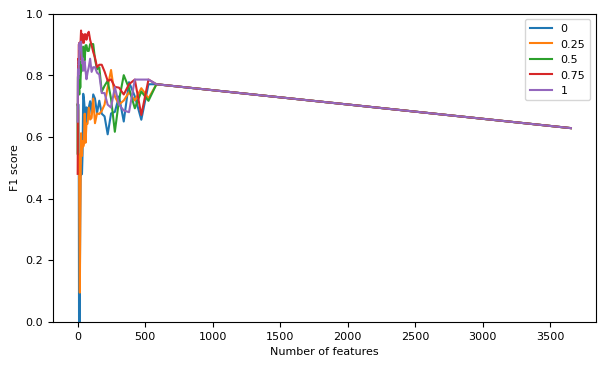

In [561]:
fig, ax = plt.subplots(1,1, figsize=(7, 4))
plt.plot(featRank_A["performance"].nFeats, featRank_A["performance"].f1) 
plt.plot(featRank_C["performance"].nFeats, featRank_C["performance"].f1) 
plt.plot(featRank_D["performance"].nFeats, featRank_D["performance"].f1) 
plt.plot(featRank_E["performance"].nFeats, featRank_E["performance"].f1) 
plt.plot(featRank_B["performance"].nFeats, featRank_B["performance"].f1) 

plt.ylim(0,1)

plt.legend(['0','0.25','0.5','0.75','1'])
plt.ylabel('F1 score')
plt.xlabel('Number of features')
plt.show()


In [562]:
figCommon = fileName_common + "fig2"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

### narrower window performance plots

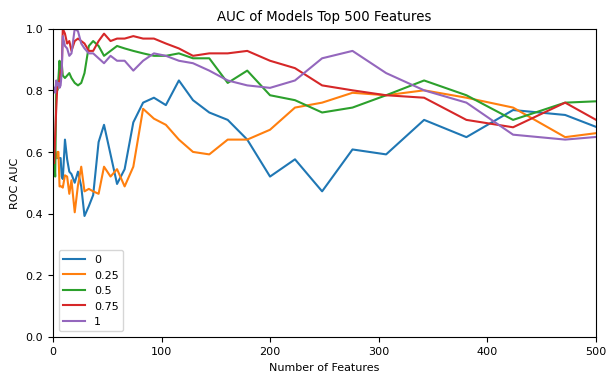

In [563]:
fig, ax = plt.subplots(1,1, figsize=(7, 4))
plt.plot(featRank_A["performance"].nFeats, featRank_A["performance"].auc) 
plt.plot(featRank_C["performance"].nFeats, featRank_C["performance"].auc) 
plt.plot(featRank_D["performance"].nFeats, featRank_D["performance"].auc) 
plt.plot(featRank_E["performance"].nFeats, featRank_E["performance"].auc)
plt.plot(featRank_B["performance"].nFeats, featRank_B["performance"].auc) 

plt.ylim(0,1)
plt.xlim(0,500)

plt.legend(['0','0.25','0.5','0.75','1'])
plt.ylabel('ROC AUC')
plt.xlabel('Number of Features')
plt.title("AUC of Models Top 500 Features")
plt.show()

In [564]:
figCommon = fileName_common + "fig1_500"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# plt.tight_layout()
fig.savefig(figPath, bbox_inches = 'tight')

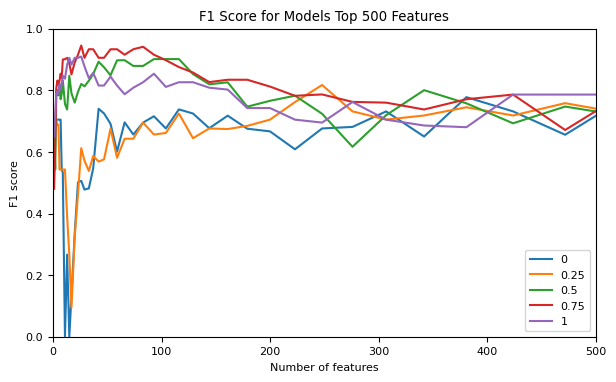

In [565]:
fig, ax = plt.subplots(1,1, figsize=(7, 4))
plt.plot(featRank_A["performance"].nFeats, featRank_A["performance"].f1) 
plt.plot(featRank_C["performance"].nFeats, featRank_C["performance"].f1) 
plt.plot(featRank_D["performance"].nFeats, featRank_D["performance"].f1) 
plt.plot(featRank_E["performance"].nFeats, featRank_E["performance"].f1) 
plt.plot(featRank_B["performance"].nFeats, featRank_B["performance"].f1) 

plt.ylim(0,1)
plt.xlim(0,500)

plt.legend(['0','0.25','0.5','0.75','1'])
plt.ylabel('F1 score')
plt.xlabel('Number of features')
plt.title("F1 Score for Models Top 500 Features")
plt.show()


In [566]:
figCommon = fileName_common + "fig2_500"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

### Input the top 3 features from your data set into the following plot for a 3D visualization

In [567]:
X.columns[featRank_D["sorted"].astype(int)]

Index(['RadTx', 'Kappa Free Light Chains Result (mg/L) Linear Forced R2',
       'Pct. Immature Gran Auto Result Desc std',
       'Urine Albumin Outcome Result Desc std',
       'total CO2 Result Linear NotForced RegresDesc 50%',
       'Kappa Free Light Chains Result (mg/L) Desc min',
       'NT Pro BNP (B-Type Natriuretic Peptide) Linear Forced intercpet',
       'Pct. Mono Result Quadratic Force coef A', 'BUN Result(mg/dL) Desc min',
       'Monocyte Result Desc 25%',
       ...
       'AST Result(U/L) Desc 75%', 'AST Result(U/L) Desc 50%',
       'AST Result(U/L) Desc 25%', 'AST Result(U/L) Desc count',
       'ALT Result(U/L) Desc 75%', 'ALT Result(U/L) Desc 50%',
       'ALT Result(U/L) Desc 25%', '1st_innerLS', '1st_midLS', '1st_LVMI'],
      dtype='object', length=3652)

In [568]:
listX = list(X.columns[featRank_D["sorted"].astype(int)])

In [569]:
fig = px.scatter_3d(dataTable, x=listX[0], y=listX[1], z=listX[2],
              color= y_column_Classification)
fig.update_traces(marker_size = 4)
fig.show()

### performance outputs
set the number of features you want to check the performance with

In [570]:
#setting number of features for performance test
fold = 0
number_feat_perf_test = 25 #describes for testing performance 
numb_features_figures = 5 #number of features to use in plots

# to use best features from a feature selection process

In [571]:
modelD_Features = featRank_D["best_features"] #to get the best features which take highest score and highest C
modelD_FeaturesInt = featRank_D["best_features"].astype(int) #convert these to ints? to use as column finding for x.columns?
modelD_numbFeatures = len(modelD_FeaturesInt) #number of features

#list of column names
modelD_FeaturesIntList = X.columns[featRank_D["best_features"].astype(int)]

In [572]:
modelE_Features = featRank_E["best_features"] #to get the best features which take highest score and highest C
modelE_FeaturesInt = featRank_E["best_features"].astype(int) #convert these to ints? to use as column finding for x.columns?
modelE_numbFeatures = len(modelE_FeaturesInt) #number of features

#list of column names
modelE_FeaturesIntList = X.columns[featRank_E["best_features"].astype(int)]

In [573]:
modelB_Features = featRank_B["best_features"] #to get the best features which take highest score and highest C
modelB_FeaturesInt = featRank_B["best_features"].astype(int) #convert these to ints? to use as column finding for x.columns?
modelB_numbFeatures = len(modelB_FeaturesInt) #number of features

#list of column names
modelB_FeaturesIntList = X.columns[featRank_B["best_features"].astype(int)]

## Figures for weighting 0.5

In [574]:
#loading from pickle: 
#to upload a pickled set use this block
pickle_file_name = 'tesTune05_object_' + fileName_header +fileName_suffix
pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
pickle_file = open(pickle_filePath, 'rb')

#to put data into an object
tesTune05 = pickle.load(pickle_file)

c:\Users\maega\anaconda3\envs\BEAT-Labs_2024-08-02\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning:

Trying to unpickle estimator SVC from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations



In [575]:
#setting the parameters for the plots below
featuresInt = modelD_FeaturesInt
numbFeatures = modelD_numbFeatures
ListFeatureColNames = modelD_FeaturesIntList

#setting the tuned SVM model for the plots below
tunedModel = tesTune05

In [576]:
CV_sets_trainANDtest_X = np.concatenate((CV_sets[fold]["train"]["X"][:,featuresInt],CV_sets[fold]["test"]["X"][:,featuresInt]), axis =0)
CV_sets_trainANDtest_y = np.concatenate((CV_sets[fold]["train"]["y"],CV_sets[fold]["test"]["y"]), axis = 0)



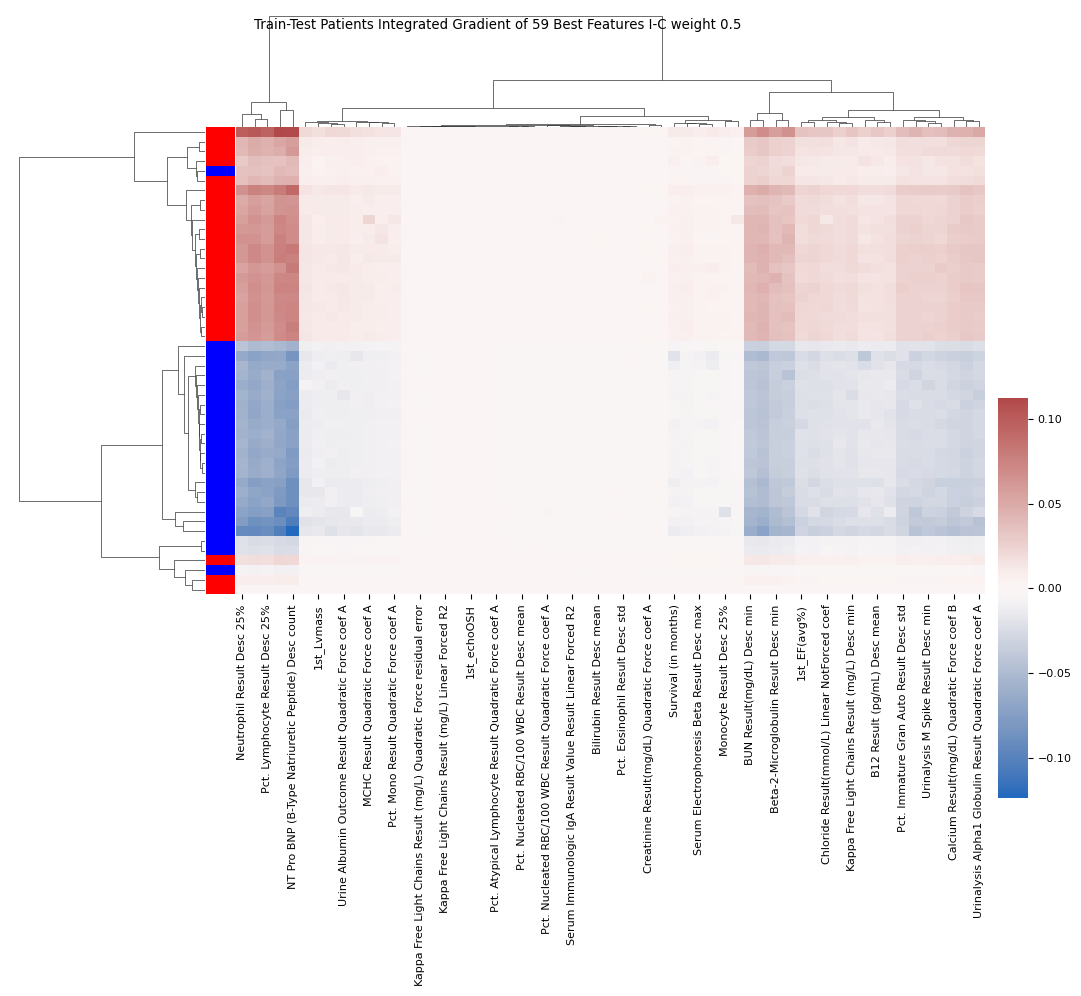

In [577]:
# CV_sets_trainANDtest_X = np.concatenate((CV_sets[fold]["train"]["X"][:,modelD_FeaturesInt],CV_sets[fold]["test"]["X"][:,modelD_FeaturesInt]), axis =0)
# CV_sets_trainANDtest_y = np.concatenate((CV_sets[fold]["train"]["y"],CV_sets[fold]["test"]["y"]), axis = 0)

IG = compute_SV_integrated_gradient(tunedModel["best_models"][fold], CV_sets_trainANDtest_X)

IGtable = pd.DataFrame(IG,columns=X.columns[modelD_FeaturesInt])

fig = clustermap(IGtable, 
           yticklabels=False,
           cmap="vlag", vmin=IGtable.min().min(), vmax=IGtable.max().max(), center = 0, 
           #row_linkage=hcRow, col_linkage=hcCol, 
           cbar_pos=(1, .2, .03, .4),
        #    row_colors=[["red","blue"][int(l=="B")+0] for l in CV_sets[0]["test"]["y"].values]
           row_colors=[["red","blue"][int(l==np.int64(1))+0] for l in CV_sets_trainANDtest_y])
plt.suptitle("Train-Test Patients Integrated Gradient of "+  str(numbFeatures)+ " Best Features I-C weight 0.5")
plt.show()

figCommon = fileName_common + "fig4_w05"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

c:\Users\maega\anaconda3\envs\BEAT-Labs_2024-08-02\lib\site-packages\shap\plots\_beeswarm.py:699: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



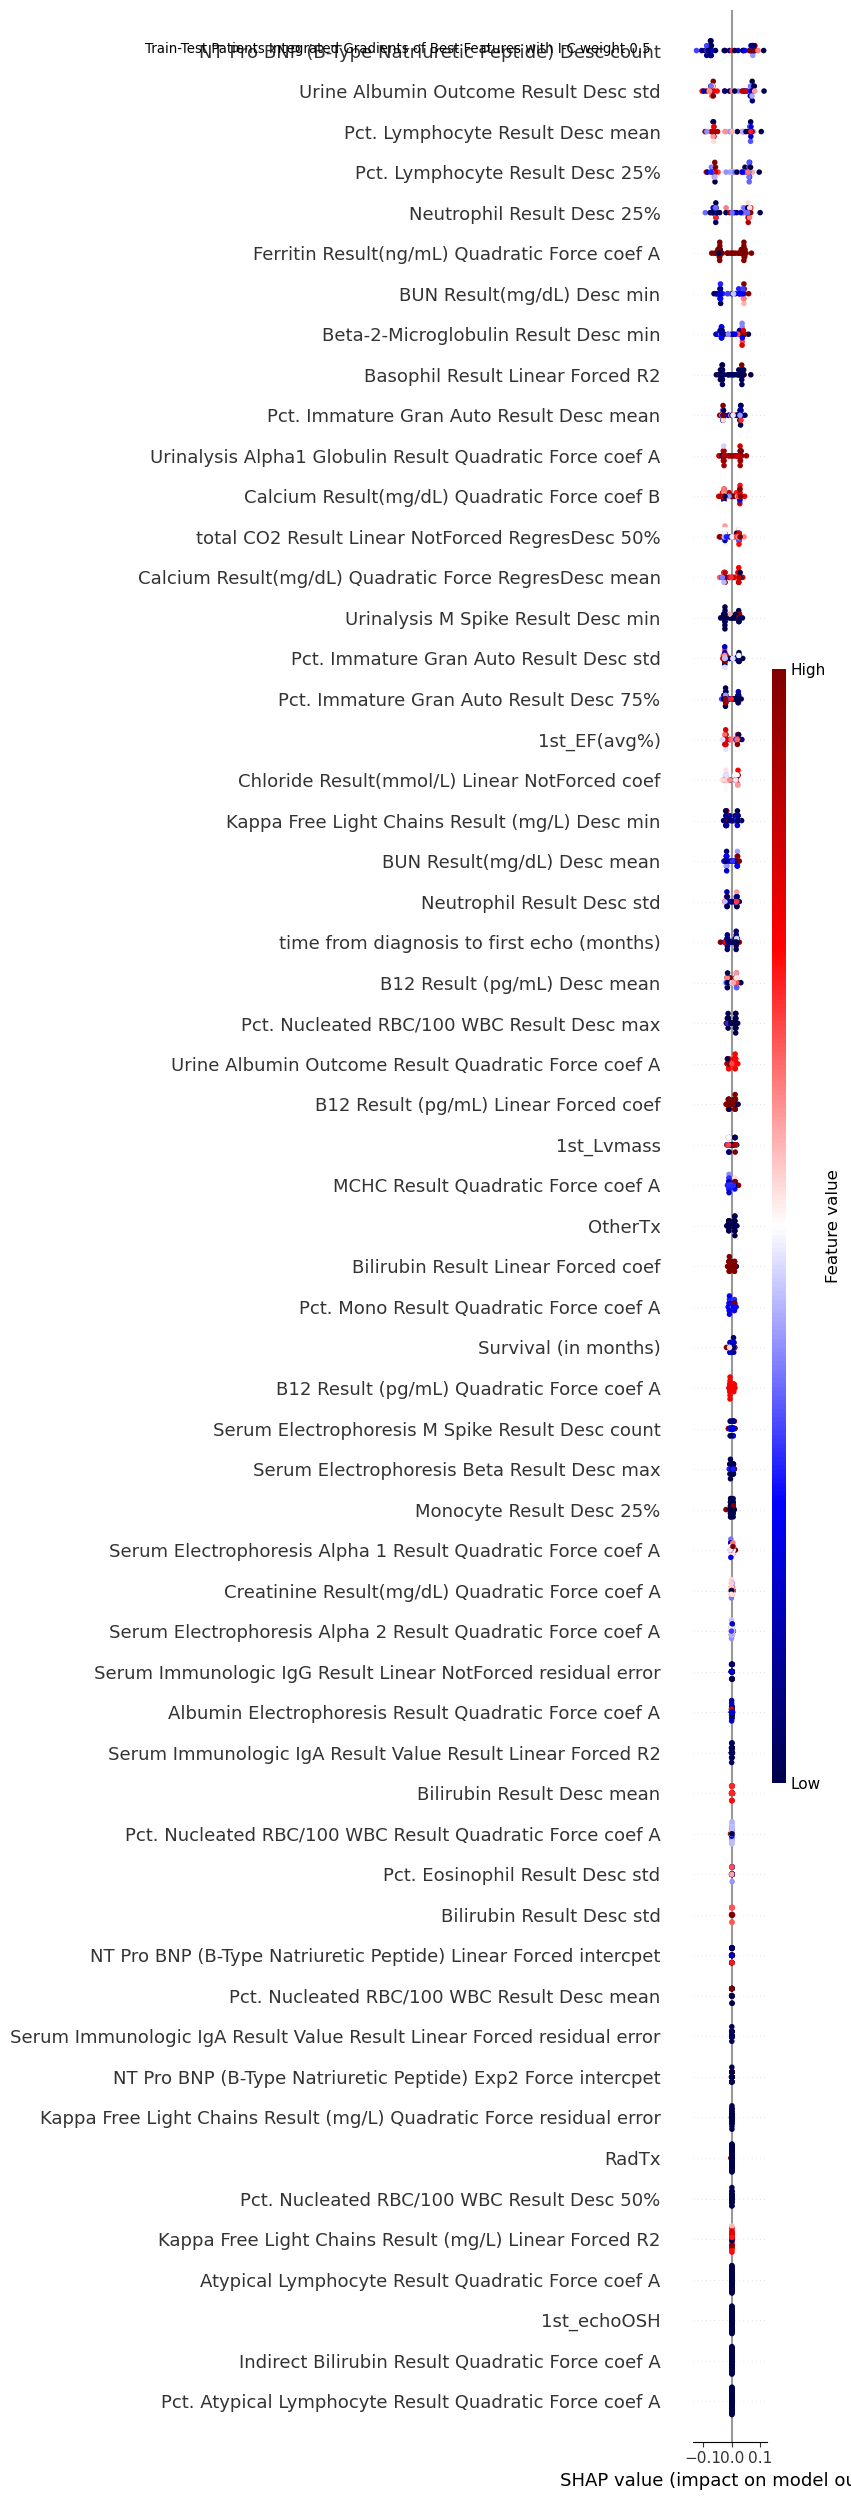

In [578]:
# number_feat_perf_test = 25
fig = shap.summary_plot(IG,  CV_sets_trainANDtest_X, max_display=numbFeatures , 
                  feature_names=ListFeatureColNames,cmap="seismic", show = False)
plt.suptitle("Train-Test Patients Integrated Gradients of Best Features with I-C weight 0.5")
figCommon = fileName_common + "fig5_w05"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
plt.savefig(figPath, bbox_inches = 'tight')

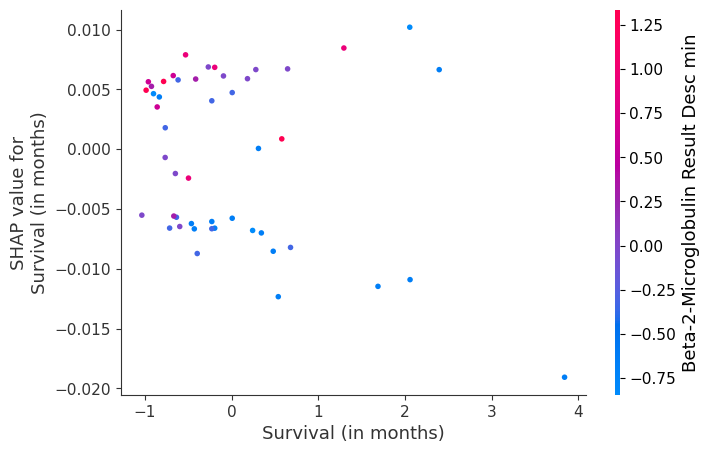

In [579]:
Xcv = pd.DataFrame(CV_sets_trainANDtest_X, 
                     index=CV_sets_trainANDtest_y,
                     columns=X.columns[modelD_FeaturesInt])

fig6_feature_to_plot= ListFeatureColNames[0]

shap.dependence_plot( fig6_feature_to_plot , IG, Xcv, show = False)

figCommon = fileName_common + "fig6_w05"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
plt.savefig(figPath, bbox_inches = 'tight')

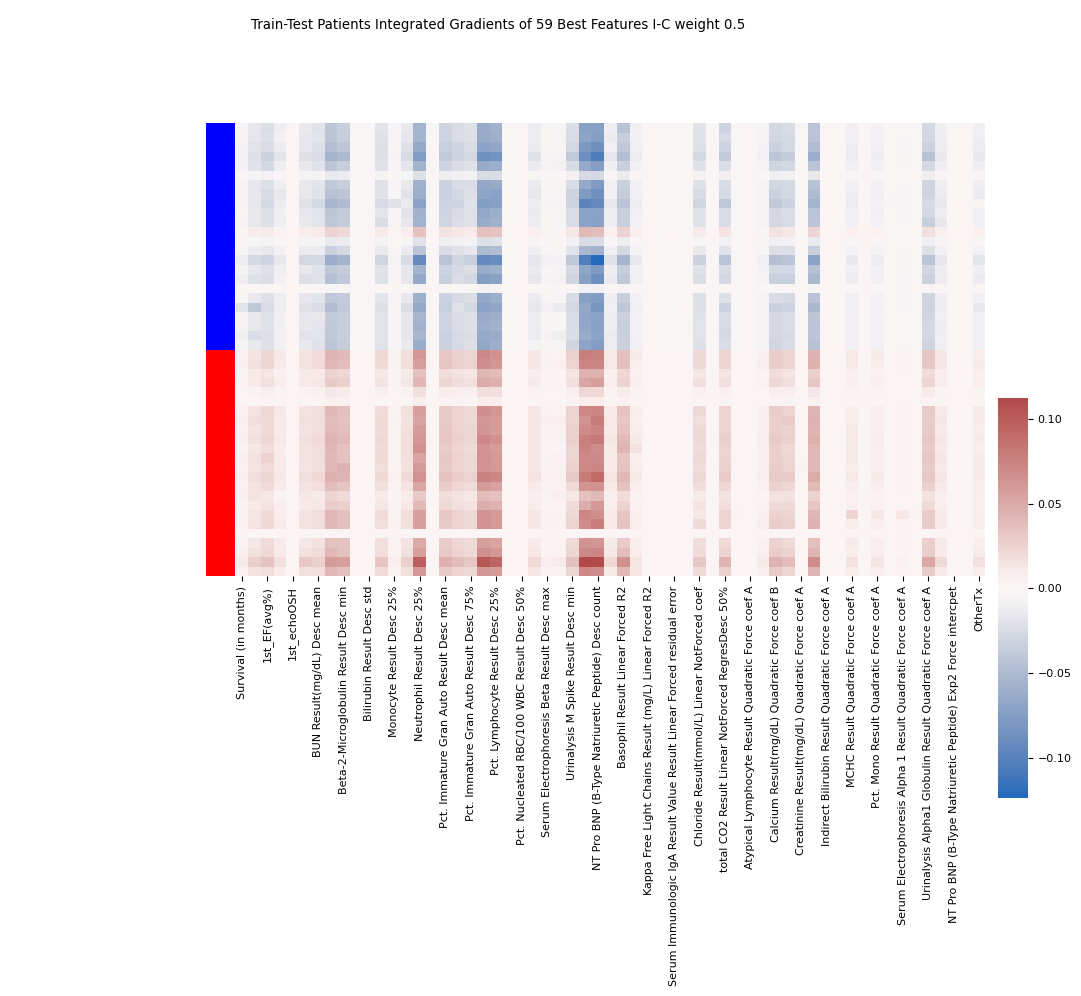

In [580]:
# Xtop3 = pd.DataFrame(CV_sets[fold]["test"]["X"][:,featRank_D["sorted"][0:topFeaturesNumber ].astype(int)], 
#                      index=CV_sets[fold]["test"]["y"],
#                      columns=X.columns[modelD_FeaturesInt])
# IG = compute_SV_integrated_gradient(tesTune05["best_models"][fold],
#                                    CV_sets[fold]["test"]["X"][:,modelD_FeaturesInt])

IGtable_wIndex = pd.DataFrame(IG, index=CV_sets_trainANDtest_y, columns=ListFeatureColNames)

IGtable_wIndex.reset_index(drop=True, inplace=True)
fig = clustermap(IGtable_wIndex.iloc[np.argsort(CV_sets_trainANDtest_y),:], 
           yticklabels=False,
           col_cluster=False,
           row_cluster=False,
           cmap="vlag", vmin=IGtable_wIndex.min().min(), vmax=IGtable_wIndex.max().max(), center = 0, 
           cbar_pos=(1, .2, .03, .4),
           row_colors=[["red","blue"][int(l==np.int64(1))+0] for l in CV_sets_trainANDtest_y[np.argsort(CV_sets_trainANDtest_y)]])

plt.suptitle("Train-Test Patients Integrated Gradients of "+ str(numbFeatures) +' Best Features I-C weight 0.5')
plt.show()

figCommon = fileName_common + "fig7_w05"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

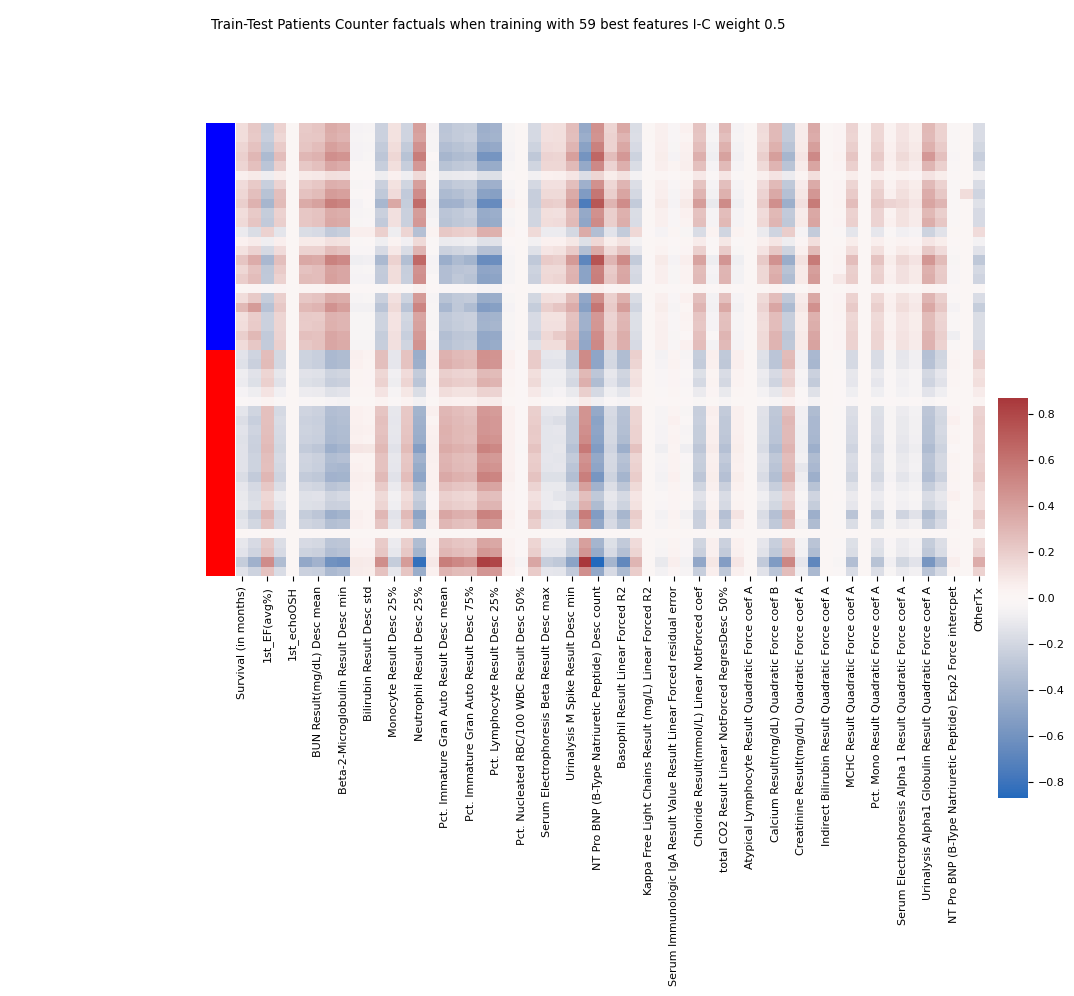

In [581]:
counterfactuals = compute_counterfactuals(tunedModel["best_models"][fold], 
                                          CV_sets_trainANDtest_X)
CFtable = pd.DataFrame(counterfactuals, 
                       index=CV_sets_trainANDtest_y,columns=X.columns[modelD_FeaturesInt])

CFtable.reset_index(drop=True, inplace=True)
fig = clustermap(CFtable.iloc[np.argsort(CV_sets_trainANDtest_y),:],#/abs(Xtop3.iloc[np.argsort(CV_sets[fold]["test"]["y"].values),:]), 
           yticklabels=False,
           col_cluster=False,
           row_cluster=False,
           cmap="vlag", vmin=CFtable.min().min(), vmax=CFtable.max().max(), center =0, 
           cbar_pos=(1, .2, .03, .4),
           row_colors=[["red","blue"][int(l==np.int64(1))+0] for l in CV_sets_trainANDtest_y[np.argsort(CV_sets_trainANDtest_y)]])
plt.suptitle("Train-Test Patients Counter factuals when training with "+ str(numbFeatures) +' best features I-C weight 0.5')
# plt.show()

figCommon = fileName_common + "fig9_w05"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

## hyper parameter tuning for best features 0.75 weighting

In [582]:
modelE_Features = featRank_E["best_features"] #to get the best features which take highest score and highest C
modelE_FeaturesInt = featRank_E["best_features"].astype(int) #convert these to ints? to use as column finding for x.columns?
modelE_numbFeatures = len(modelE_FeaturesInt) #number of features

#list of column names
modelE_FeaturesIntList = X.columns[featRank_E["best_features"].astype(int)]

In [583]:
#setting the parameters for the plots below
featuresInt = modelE_FeaturesInt
numbFeatures = modelE_numbFeatures
ListFeatureColNames = modelE_FeaturesIntList

In [584]:
#loading from pickle: 
#to upload a pickled set use this block
pickle_file_name = 'tesTune075_object_' + fileName_header +fileName_suffix
pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
pickle_file = open(pickle_filePath, 'rb')

#to put data into an object
tesTune075 = pickle.load(pickle_file)

c:\Users\maega\anaconda3\envs\BEAT-Labs_2024-08-02\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning:

Trying to unpickle estimator SVC from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations



In [585]:
#setting the tuned SVM model for the plots below
tunedModel = tesTune075

In [586]:
#feature contribution cluster map for all test and train patients
CV_sets_trainANDtest_X = np.concatenate((CV_sets[fold]["train"]["X"][:,featuresInt],CV_sets[fold]["test"]["X"][:,featuresInt]), axis =0)
CV_sets_trainANDtest_y = np.concatenate((CV_sets[fold]["train"]["y"],CV_sets[fold]["test"]["y"]), axis = 0)



In [587]:
feat_contribution = compute_SV_decision_perturbation(tunedModel["best_models"][fold],CV_sets_trainANDtest_X)
# FItable = pd.DataFrame(feat_contribution, index=CV_sets_trainANDtest_y,columns=ListFeatureColNames)

# FItable.reset_index(drop=True, inplace=True)
# fig = clustermap(FItable.iloc[np.argsort(CV_sets_trainANDtest_y),:], 
#            yticklabels=False,
#            cmap="vlag", vmin=-0.4, vmax=0.4,
#            #row_linkage=hcRow, col_linkage=hcCol, 
#            row_cluster=False,col_cluster=False,
#            cbar_pos=(1, .2, .03, .4),
#            row_colors=[["red","blue"][int(l==np.int64(1))+0] for l in CV_sets_trainANDtest_y[np.argsort(CV_sets_trainANDtest_y)]])
# plt.suptitle("Contribution test-train when training with best "+  str(numbFeatures)+ " features I-C weight 0.75")

# figCommon = fileName_common + "fig3_2_w075"
# figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# fig.savefig(figPath, bbox_inches = 'tight')

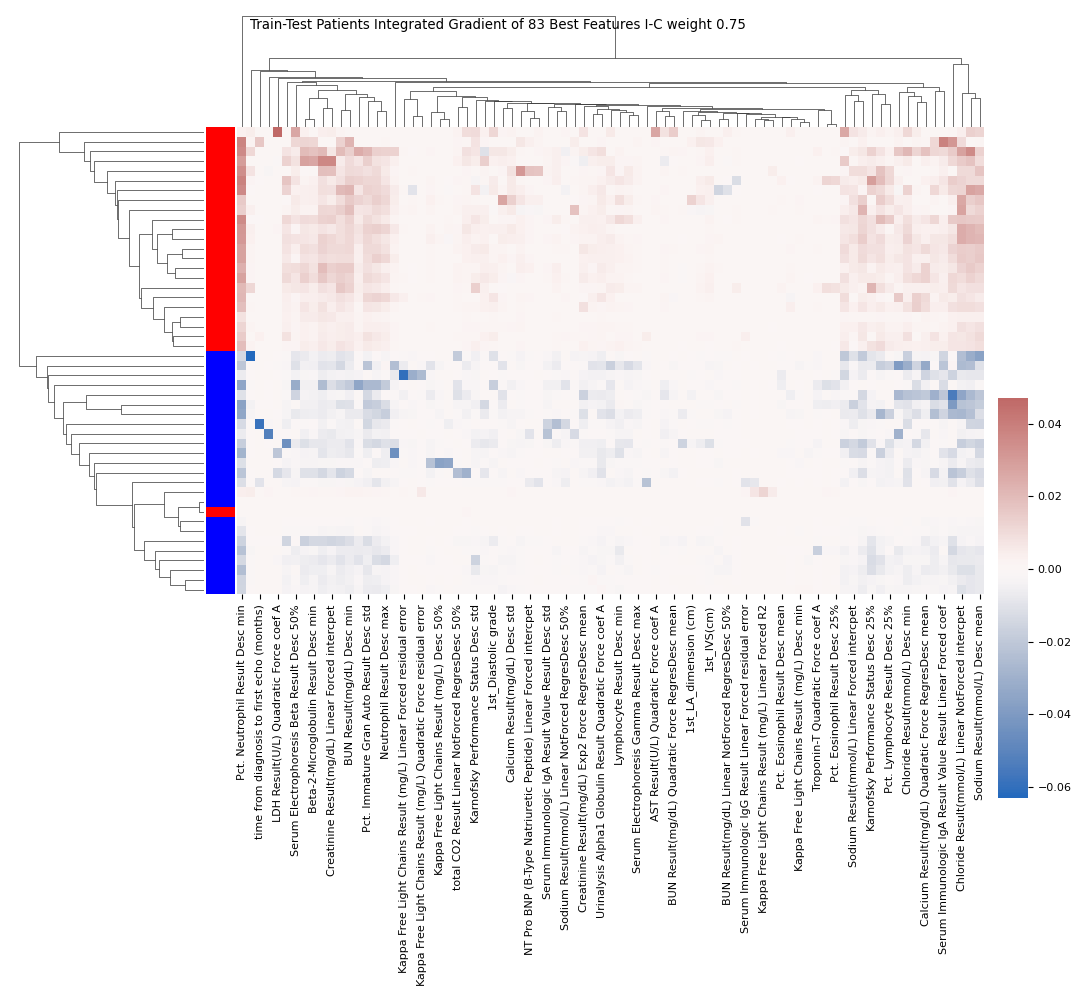

In [588]:
#integrated gradient cluster map with heigharchical clustering

IG = compute_SV_integrated_gradient(tunedModel["best_models"][fold], CV_sets_trainANDtest_X)

IGtable = pd.DataFrame(IG,columns=ListFeatureColNames)

fig = clustermap(IGtable, 
           yticklabels=False,
           cmap="vlag", vmin=IGtable.min().min(), vmax=IGtable.max().max(), center =0, 
           #row_linkage=hcRow, col_linkage=hcCol, 
           cbar_pos=(1, .2, .03, .4),
        #    row_colors=[["red","blue"][int(l=="B")+0] for l in CV_sets[0]["test"]["y"].values]
           row_colors=[["red","blue"][int(l==np.int64(1))+0] for l in CV_sets_trainANDtest_y])
plt.suptitle("Train-Test Patients Integrated Gradient of "+  str(numbFeatures)+ " Best Features I-C weight 0.75")
plt.show()

figCommon = fileName_common + "fig4_w075"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

c:\Users\maega\anaconda3\envs\BEAT-Labs_2024-08-02\lib\site-packages\shap\plots\_beeswarm.py:699: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



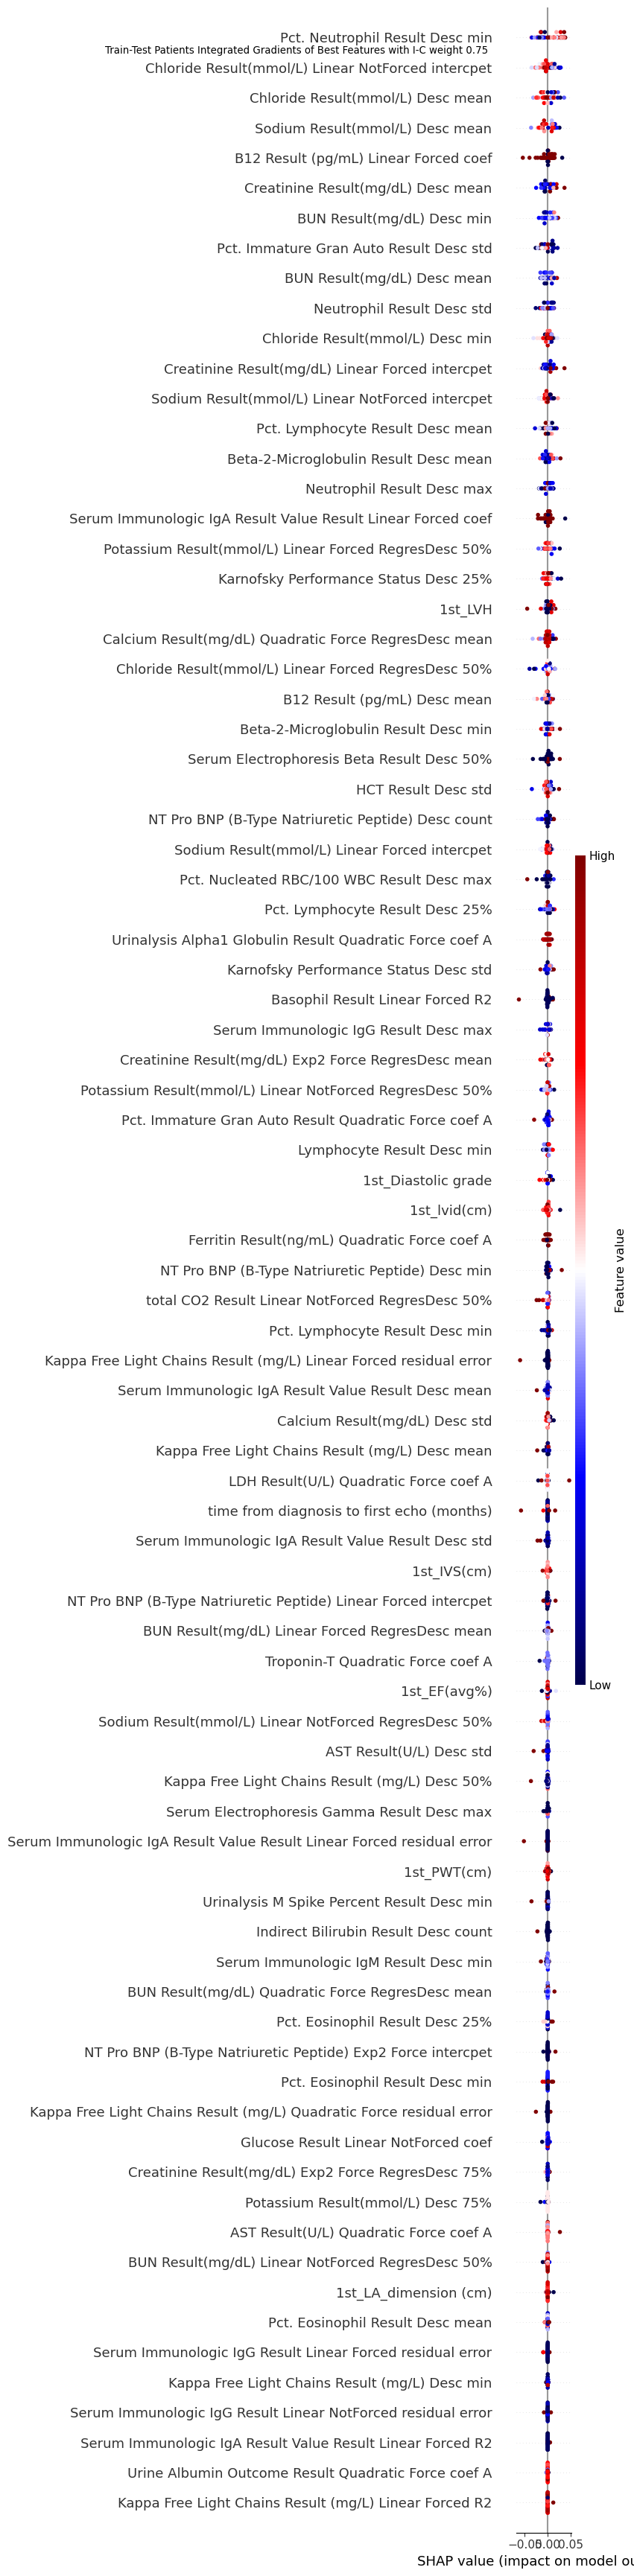

In [589]:
#shap plot for integrated gradients
fig = shap.summary_plot(IG,  CV_sets_trainANDtest_X, max_display=numbFeatures , 
                  feature_names=ListFeatureColNames,cmap="seismic", show = False)
plt.suptitle("Train-Test Patients Integrated Gradients of Best Features with I-C weight 0.75")
figCommon = fileName_common + "fig5_w075"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
plt.savefig(figPath, bbox_inches = 'tight')

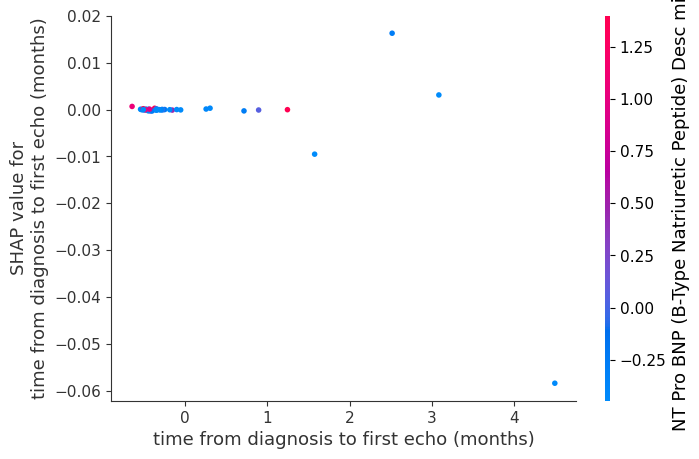

In [590]:
#shap dependence plot
Xcv = pd.DataFrame(CV_sets_trainANDtest_X, 
                     index=CV_sets_trainANDtest_y,
                     columns=ListFeatureColNames)

fig6_feature_to_plot= ListFeatureColNames[0]

shap.dependence_plot( fig6_feature_to_plot , IG, Xcv, show = False)

figCommon = fileName_common + "fig6_w075"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
plt.savefig(figPath, bbox_inches = 'tight')

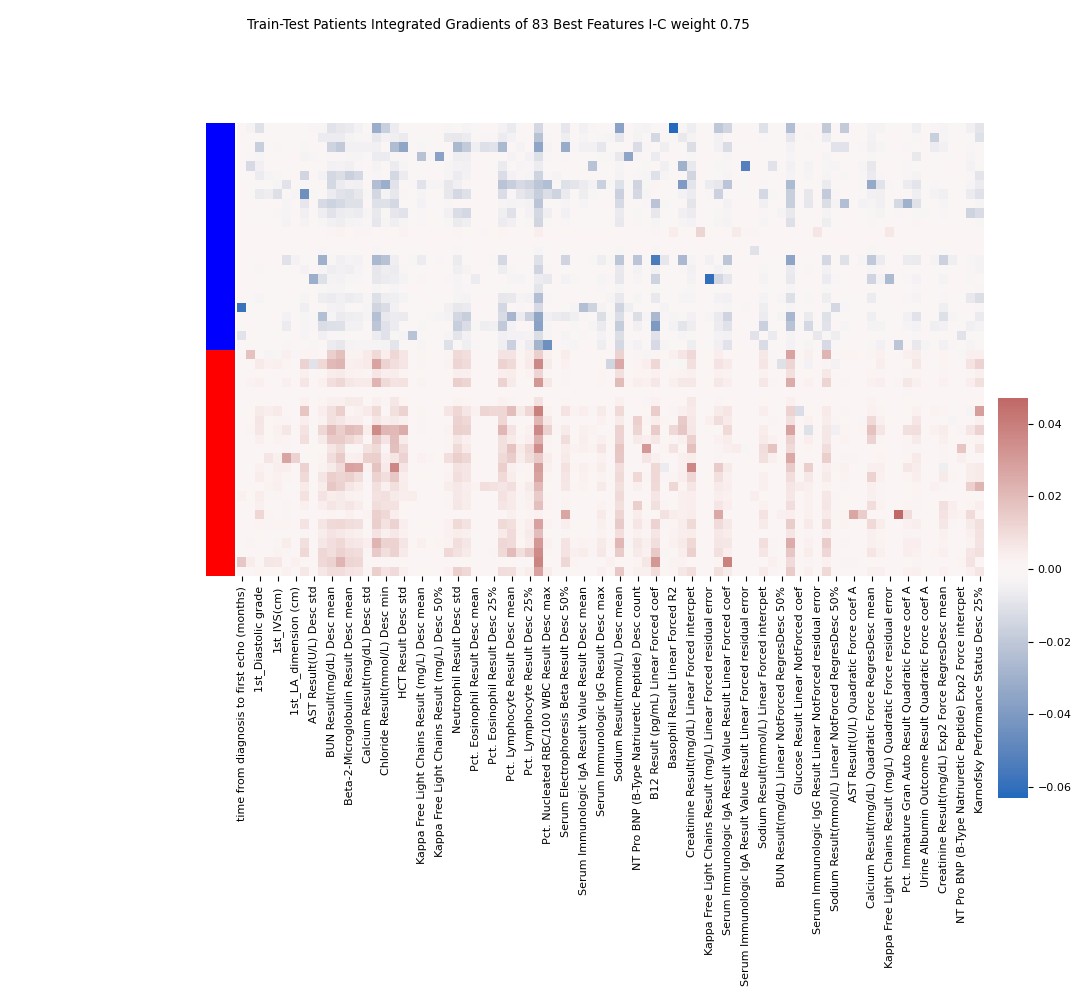

In [591]:
#cluster map of integrated gradients sorted by index
IGtable_wIndex = pd.DataFrame(IG, index=CV_sets_trainANDtest_y, columns=ListFeatureColNames)

IGtable_wIndex.reset_index(drop=True, inplace=True)
fig = clustermap(IGtable_wIndex.iloc[np.argsort(CV_sets_trainANDtest_y),:], 
           yticklabels=False,
           col_cluster=False,
           row_cluster=False,
           cmap="vlag", vmin=IGtable_wIndex.min().min(), vmax=IGtable_wIndex.max().max(), center = 0,
           cbar_pos=(1, .2, .03, .4),
           row_colors=[["red","blue"][int(l==np.int64(1))+0] for l in CV_sets_trainANDtest_y[np.argsort(CV_sets_trainANDtest_y)]])

plt.suptitle("Train-Test Patients Integrated Gradients of "+ str(modelE_numbFeatures) +' Best Features I-C weight 0.75')
plt.show()

figCommon = fileName_common + "fig7_w075"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

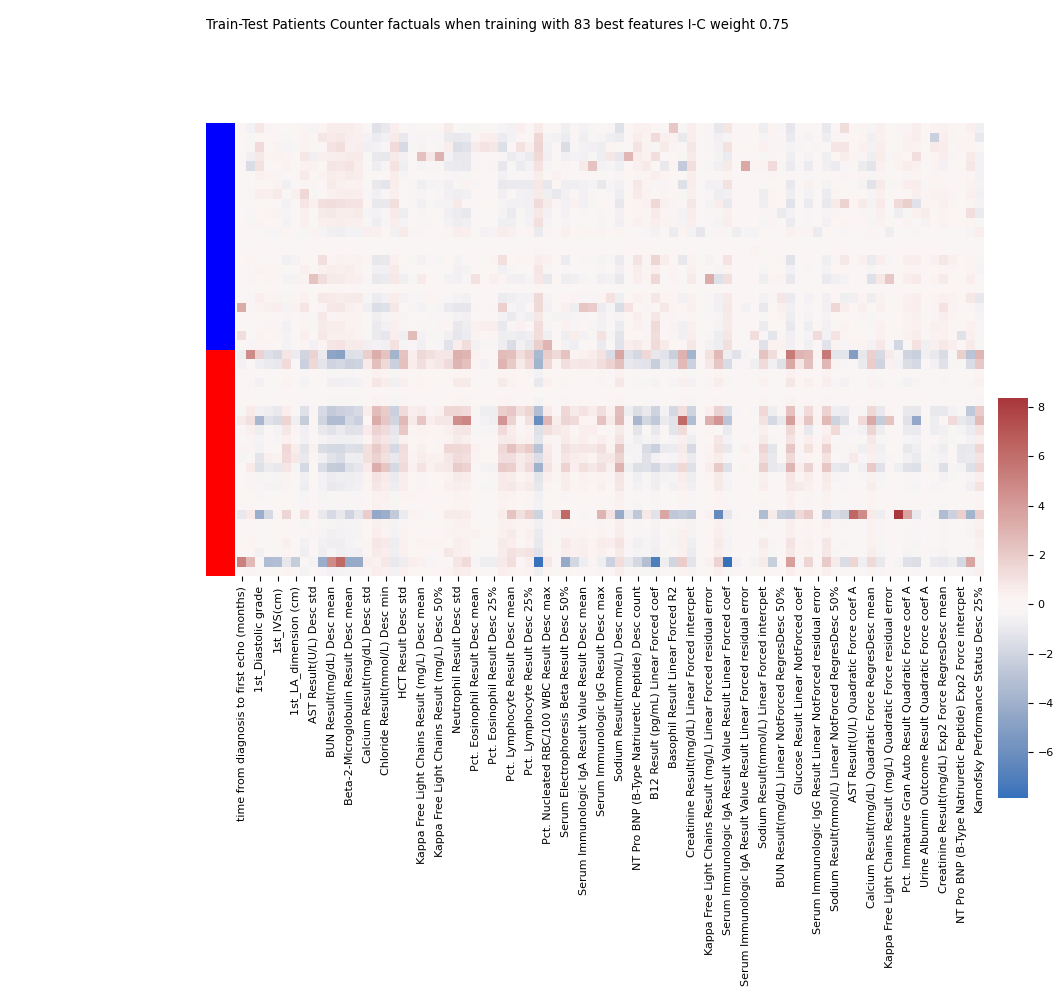

In [592]:
#counter factuals map
counterfactuals = compute_counterfactuals(tunedModel["best_models"][fold], 
                                          CV_sets_trainANDtest_X)
CFtable = pd.DataFrame(counterfactuals, 
                       index=CV_sets_trainANDtest_y,columns=ListFeatureColNames)

CFtable.reset_index(drop=True, inplace=True)
fig = clustermap(CFtable.iloc[np.argsort(CV_sets_trainANDtest_y),:],#/abs(Xtop3.iloc[np.argsort(CV_sets[fold]["test"]["y"].values),:]), 
           yticklabels=False,
           col_cluster=False,
           row_cluster=False,
           cmap="vlag", vmin=CFtable.min().min(), vmax=CFtable.max().max(), center = 0, 
           cbar_pos=(1, .2, .03, .4),
           row_colors=[["red","blue"][int(l==np.int64(1))+0] for l in CV_sets_trainANDtest_y[np.argsort(CV_sets_trainANDtest_y)]])
plt.suptitle("Train-Test Patients Counter factuals when training with "+ str(numbFeatures) +' best features I-C weight 0.75')
# plt.show()

figCommon = fileName_common + "fig9_w075"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

## hyperparameter tuning using list of best features from feature selection with only contribution featRank_B

In [593]:
modelB_Features = featRank_B["best_features"] #to get the best features which take highest score and highest C
modelB_FeaturesInt = featRank_B["best_features"].astype(int) #convert these to ints? to use as column finding for x.columns?
modelB_numbFeatures = len(modelB_FeaturesInt) #number of features

#list of column names
modelB_FeaturesIntList = X.columns[featRank_B["best_features"].astype(int)]

In [594]:
#setting the parameters for the plots below
featuresInt = modelB_FeaturesInt
numbFeatures = modelB_numbFeatures
ListFeatureColNames = modelB_FeaturesIntList

In [595]:
#creation of classifier using the features found in ranking above
#creation of tesTune_1
tesTune100 = tuneSVM(svc, CV_sets, score_method = svc_score().score, costs = C_range, gammas = gamma_range,feature_index=featuresInt)
print(tesTune100["best_params"])

   c         g        f1  auc     score
0  2  0.003906  0.905556  1.0  0.952778


In [596]:
# #loading from pickle: 
# #to upload a pickled set use this block
# pickle_file_name = 'tesTune100_object_' + fileName_header +fileName_suffix
# pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
# pickle_file = open(pickle_filePath, 'rb')

# #to put data into an object
# tesTune100 = pickle.load(pickle_file)

In [597]:
#setting the tuned SVM model for the plots below
tunedModel = tesTune100

In [598]:
#feature contribution cluster map for all test and train patients
CV_sets_trainANDtest_X = np.concatenate((CV_sets[fold]["train"]["X"][:,featuresInt],CV_sets[fold]["test"]["X"][:,featuresInt]), axis =0)
CV_sets_trainANDtest_y = np.concatenate((CV_sets[fold]["train"]["y"],CV_sets[fold]["test"]["y"]), axis = 0)



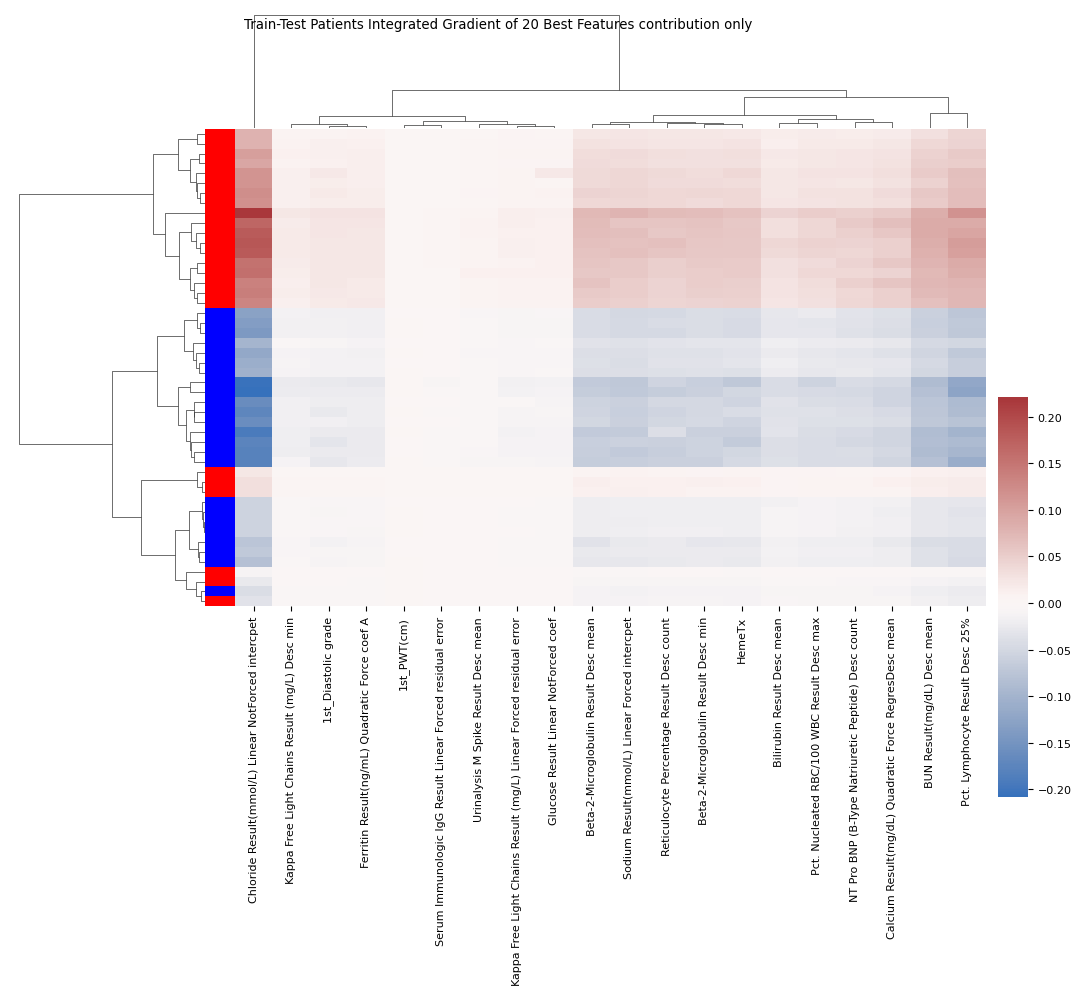

In [599]:
#integrated gradient cluster map with heigharchical clustering

IG = compute_SV_integrated_gradient(tunedModel["best_models"][fold], CV_sets_trainANDtest_X)

IGtable = pd.DataFrame(IG,columns=ListFeatureColNames)

fig = clustermap(IGtable, 
           yticklabels=False,
           cmap="vlag", vmin=IGtable.min().min(), vmax=IGtable.max().max(), center = 0, 
           #row_linkage=hcRow, col_linkage=hcCol, 
           cbar_pos=(1, .2, .03, .4),
        #    row_colors=[["red","blue"][int(l=="B")+0] for l in CV_sets[0]["test"]["y"].values]
           row_colors=[["red","blue"][int(l==np.int64(1))+0] for l in CV_sets_trainANDtest_y])
plt.suptitle("Train-Test Patients Integrated Gradient of "+  str(numbFeatures)+ " Best Features contribution only")
plt.show()

figCommon = fileName_common + "fig4_w100"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

c:\Users\maega\anaconda3\envs\BEAT-Labs_2024-08-02\lib\site-packages\shap\plots\_beeswarm.py:699: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



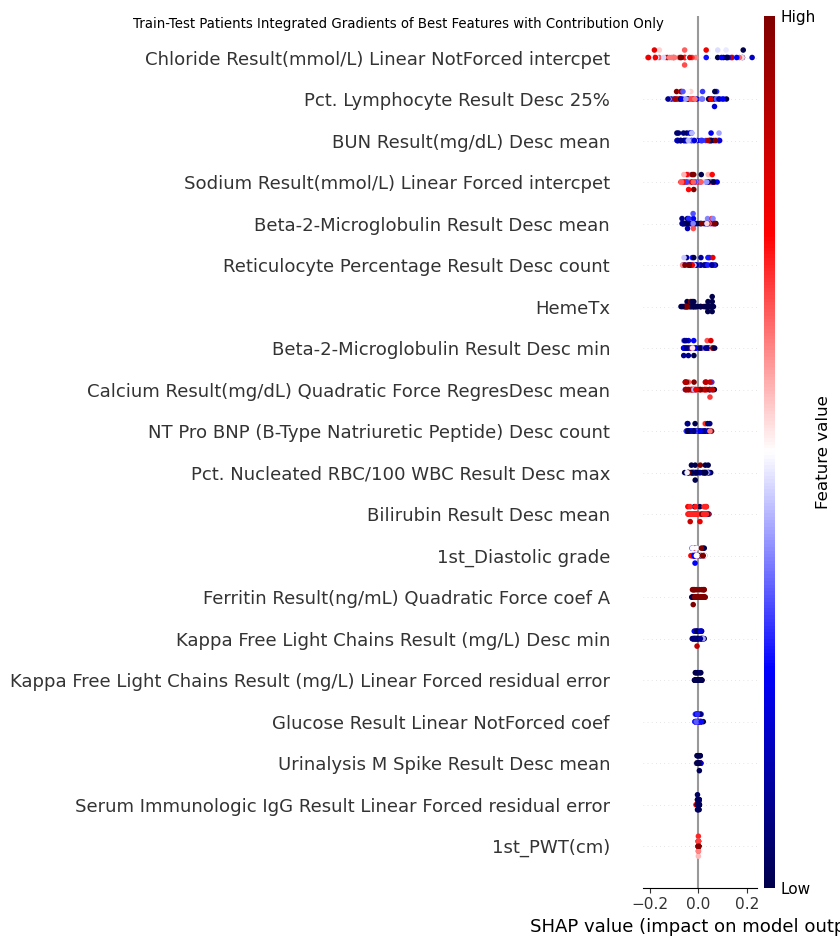

In [600]:
#shap plot for integrated gradients
fig = shap.summary_plot(IG,  CV_sets_trainANDtest_X, max_display=numbFeatures , 
                  feature_names=ListFeatureColNames,cmap="seismic", show = False)
plt.suptitle("Train-Test Patients Integrated Gradients of Best Features with Contribution Only")
figCommon = fileName_common + "fig5_w100"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
plt.savefig(figPath, bbox_inches = 'tight')

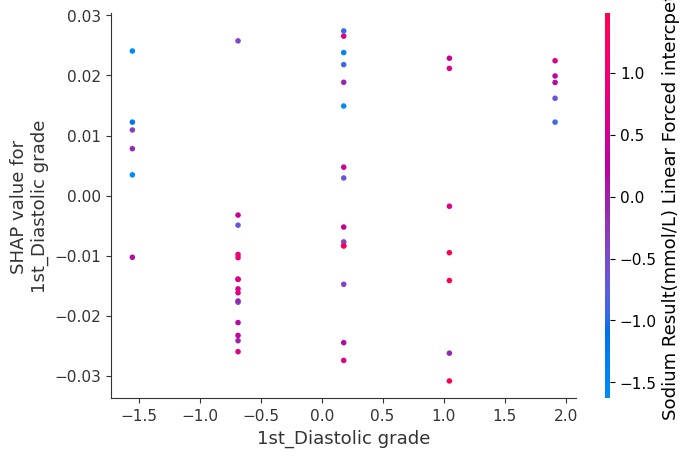

In [601]:
#shap dependence plot
Xcv = pd.DataFrame(CV_sets_trainANDtest_X, 
                     index=CV_sets_trainANDtest_y,
                     columns=ListFeatureColNames)

fig6_feature_to_plot= ListFeatureColNames[0]

shap.dependence_plot( fig6_feature_to_plot , IG, Xcv, show = False)

figCommon = fileName_common + "fig6_w100"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
plt.savefig(figPath, bbox_inches = 'tight')

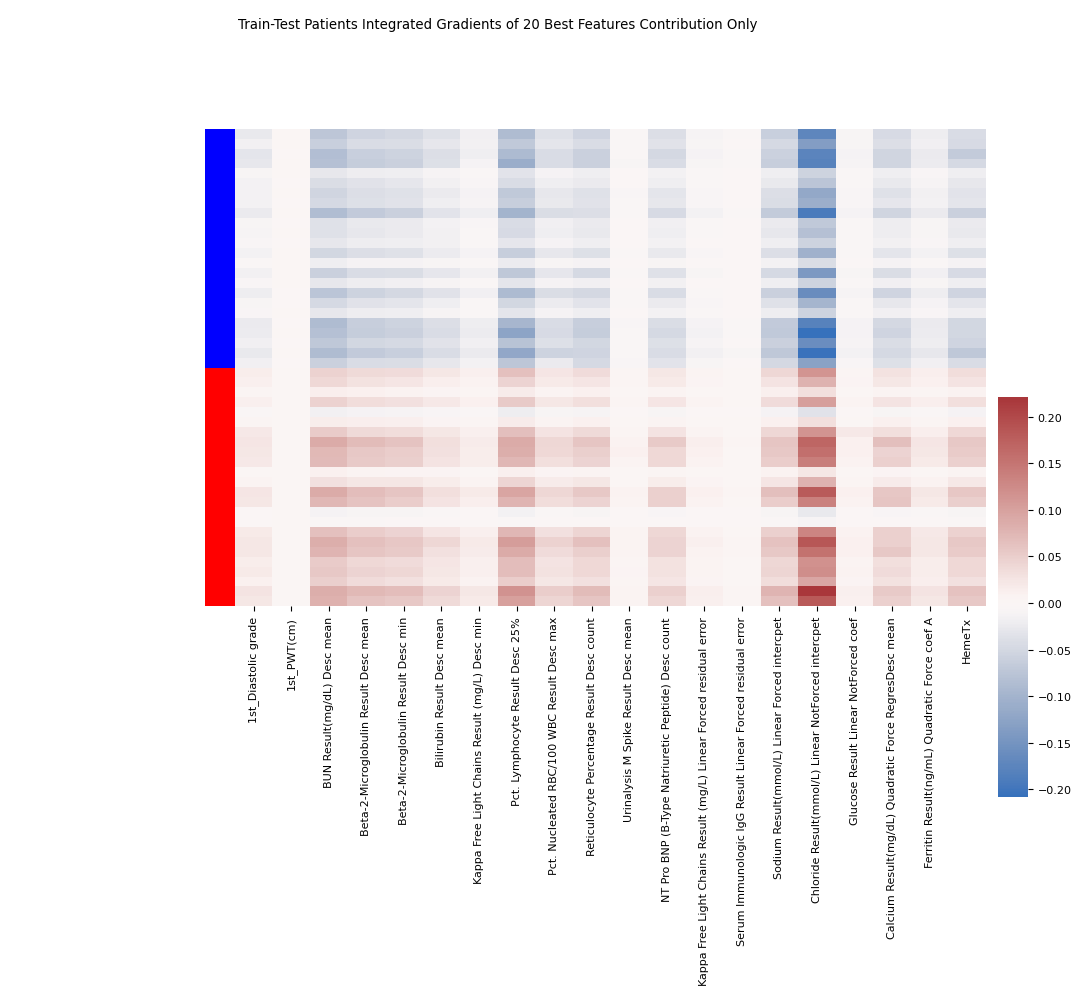

In [602]:
#cluster map of integrated gradients sorted by index
IGtable_wIndex = pd.DataFrame(IG, index=CV_sets_trainANDtest_y, columns=ListFeatureColNames)

IGtable_wIndex.reset_index(drop=True, inplace=True)
fig = clustermap(IGtable_wIndex.iloc[np.argsort(CV_sets_trainANDtest_y),:], 
           yticklabels=False,
           col_cluster=False,
           row_cluster=False,
           cmap="vlag", vmin=IGtable_wIndex.min().min(), vmax=IGtable_wIndex.max().max(), center = 0,
           cbar_pos=(1, .2, .03, .4),
           row_colors=[["red","blue"][int(l==np.int64(1))+0] for l in CV_sets_trainANDtest_y[np.argsort(CV_sets_trainANDtest_y)]])

plt.suptitle("Train-Test Patients Integrated Gradients of "+ str(numbFeatures) +' Best Features Contribution Only')
plt.show()

figCommon = fileName_common + "fig7_w100"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

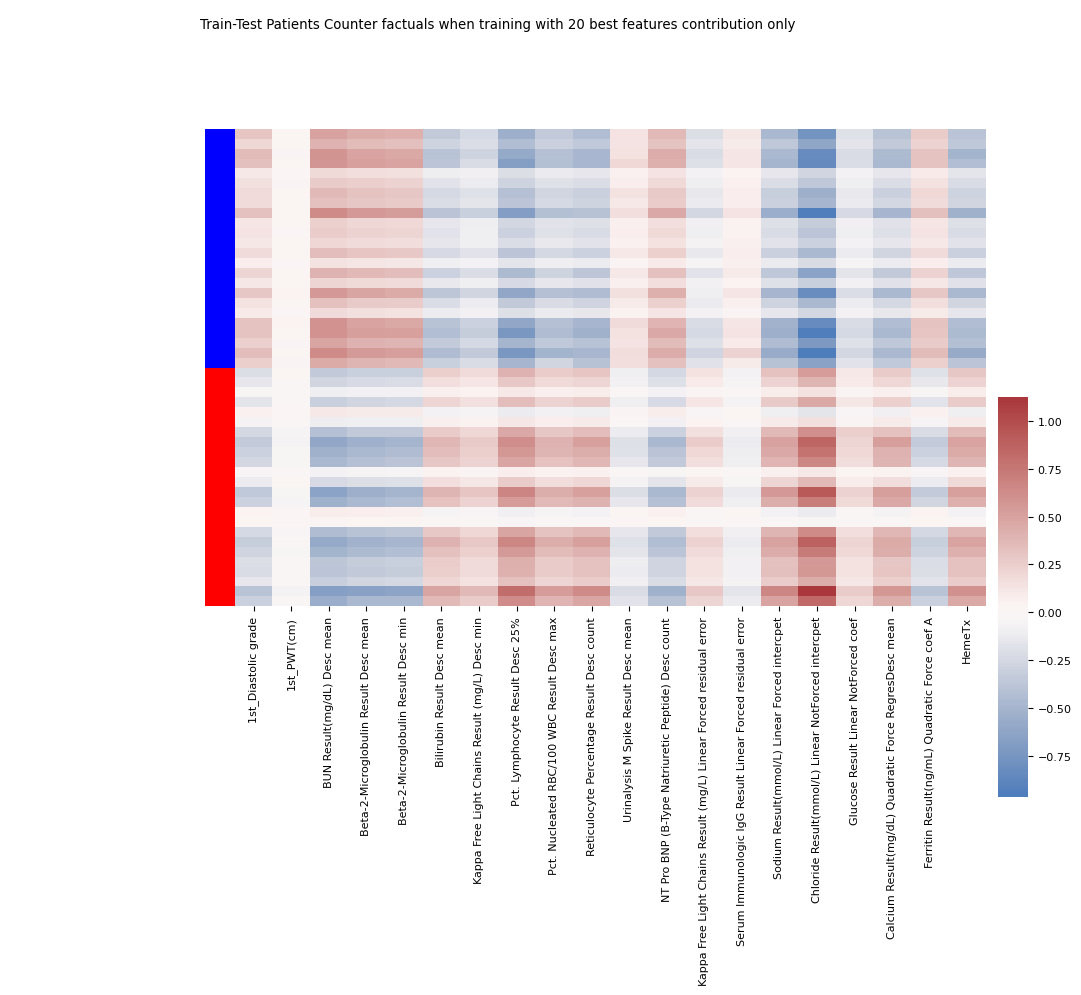

In [603]:
#counter factuals map
counterfactuals = compute_counterfactuals(tunedModel["best_models"][fold], 
                                          CV_sets_trainANDtest_X)
CFtable = pd.DataFrame(counterfactuals, 
                       index=CV_sets_trainANDtest_y,columns=ListFeatureColNames)

CFtable.reset_index(drop=True, inplace=True)
fig = clustermap(CFtable.iloc[np.argsort(CV_sets_trainANDtest_y),:],#/abs(Xtop3.iloc[np.argsort(CV_sets[fold]["test"]["y"].values),:]), 
           yticklabels=False,
           col_cluster=False,
           row_cluster=False,
           cmap="vlag", vmin=CFtable.min().min(), vmax=CFtable.max().max(), center =0, 
           cbar_pos=(1, .2, .03, .4),
           row_colors=[["red","blue"][int(l==np.int64(1))+0] for l in CV_sets_trainANDtest_y[np.argsort(CV_sets_trainANDtest_y)]])
plt.suptitle("Train-Test Patients Counter factuals when training with "+ str(numbFeatures) +' best features contribution only')
# plt.show()

figCommon = fileName_common + "fig9_w100"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')